## Where is the best place in the Boston area for families who like outdoor activities to live?

#### This analysis uses six indicators to assess ideal locations for individials and families to live who care about having easy access to outdoor activities in the Boston area. The analysis occurs within the Boston MPO boundary and produces the top zip code areas based on the following six indicators. 

1. Farmers Markets (provided data) - Euclidean Distance
2. Tree Canopy Raster (provided data) 
3. Bike trails (outside, from MassGIS) - Euclidean Distance
4. Public pools (outside, from MassGIS) - Euclidean Distance
5. Blue bikes (outside, from BlueBikes) - Euclidean Distance
6. (Time allowing) Maybe download data on coffee shops? Reference USA - Euclidean Distance

In [124]:
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.plot import show
from rasterio import features


import numpy as np

from scipy import ndimage
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import contextily as cx
import folium

In [2]:
#bring in MPO boundary file

mpo_boundaries = gpd.read_file('Data/MPO_Boundary/MPO_Boundaries/MPO_Boundaries.shp')
mpo_boundaries

,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,2,Berkshire,None,1970-01-01,None,1970-01-01,{08FDA544-18B0-412A-B442-287E53E987F7},2.451015e+09,2.471530e+05,"POLYGON ((-8128884.676 5272654.345, -8128962.2..."
1,3,Cape Cod,None,1970-01-01,None,1970-01-01,{B6CD90CF-2F7D-43F2-B251-FA7F8E00EF01},1.067067e+09,1.288227e+06,"MULTIPOLYGON (((-7813968.781 5173329.197, -781..."
2,4,Central Massachusetts,None,1970-01-01,None,1970-01-01,{CC777E14-53C8-42AD-B421-71444DA0BB60},2.487546e+09,2.683265e+05,"POLYGON ((-7977225.352 5223837.273, -7973861.8..."
3,5,Franklin,None,1970-01-01,None,1970-01-01,{4804E708-6B89-4A85-9383-BD91F7589981},1.876456e+09,2.527017e+05,"POLYGON ((-8046511.241 5269691.856, -8045276.8..."
4,6,Montachusett,None,1970-01-01,None,1970-01-01,{F315DA63-C9CF-40EE-8AA7-5ABA2E1FD528},1.772355e+09,2.748684e+05,"POLYGON ((-7976246.504 5267152.001, -7976121.9..."
5,7,Martha's Vineyard,None,1970-01-01,None,1970-01-01,{84077DC9-D5D1-471D-9A64-1E5748F80B92},2.757449e+08,3.701721e+05,"MULTIPOLYGON (((-7859473.886 5083806.270, -785..."
6,8,Merrimack Valley,None,1970-01-01,None,1970-01-01,{C09CD5BA-4FE1-45DD-838E-19F2ECF618DB},7.188680e+08,3.847121e+05,"MULTIPOLYGON (((-7890949.271 5294156.354, -788..."
7,9,Northern Middlesex,None,1970-01-01,None,1970-01-01,{5B2D231C-F8EB-4768-AB7F-F9D02B3EDBBD},5.073539e+08,1.410283e+05,"POLYGON ((-7922038.111 5250986.670, -7923186.5..."
8,10,Nantucket,None,1970-01-01,None,1970-01-01,{633A0B7F-266B-4F07-AA30-EC320231ADAA},1.266795e+08,1.680333e+05,"MULTIPOLYGON (((-7797087.819 5069759.518, -779..."
9,11,Pioneer Valley,None,1970-01-01,None,1970-01-01,{B01F3417-DC74-4561-AE49-935ACC6EF1FF},3.054352e+09,3.206858e+05,"POLYGON ((-8049986.018 5212603.033, -8049953.4..."


In [3]:
#select just Boston Region MPO
#reproject to epsg=6491

boston_mpo_area = mpo_boundaries[mpo_boundaries['MPO']=='Boston Region'].copy()
boston_mpo_area.to_crs('epsg:6491', inplace=True)

<AxesSubplot:>

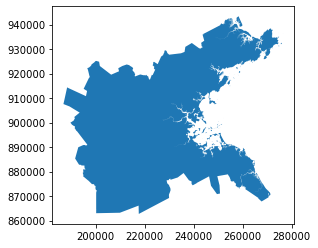

In [4]:
boston_mpo_area.plot()


In [5]:
#boston_mpo_area.geometry.iat[0]

In [6]:
boston_mpo_area.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
#bring in zcta shapefile
#reproject to epsg=6491

zcta = gpd.read_file('Data/ZCTA_boundary/tl_2010_25_zcta510/tl_2010_25_zcta510.shp')
zcta.to_crs('epsg:6491', inplace=True)

<AxesSubplot:>

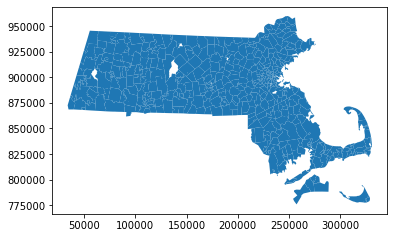

In [8]:
zcta.plot()

In [9]:
zcta.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,25,02536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"POLYGON ((275712.154 812608.480, 275688.314 81..."
1,25,02556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"POLYGON ((273020.046 818874.990, 272816.173 81..."
2,25,02540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"POLYGON ((273020.046 818874.990, 273126.263 81..."
3,25,02646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"POLYGON ((318297.748 826255.912, 318348.040 82..."
4,25,01237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((57335.091 917317.398, 57310.861 9173..."


In [10]:
zcta.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [11]:
zcta.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,25,02536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"POLYGON ((275712.154 812608.480, 275688.314 81..."
1,25,02556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"POLYGON ((273020.046 818874.990, 272816.173 81..."
2,25,02540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"POLYGON ((273020.046 818874.990, 273126.263 81..."
3,25,02646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"POLYGON ((318297.748 826255.912, 318348.040 82..."
4,25,01237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((57335.091 917317.398, 57310.861 9173..."


In [12]:
#coast = gpd.read_file('Data/OUTLINE25K_POLY/OUTLINE25K_POLY.shp')

In [13]:
#coast.crs

In [14]:
#coast.to_crs('epsg:6491', inplace=True)

In [15]:
#coast.plot()

In [16]:
#coast_zips = gpd.clip(zcta, coast)

In [17]:
#coast_zips.plot()

In [18]:
#coast_zips.centroid.within(boston_mpo_area.geometry.iat[0])

In [19]:
#boston_zips_2 = coast_zips[coast_zips.centroid.within(boston_mpo_area.geometry.iat[0])]


In [20]:

#boston_zips_2.plot()

In [21]:
#clip to get zip code poloygons for just Boston MPO
#original clip

boston_zips = gpd.clip(zcta, boston_mpo_area)



<AxesSubplot:>

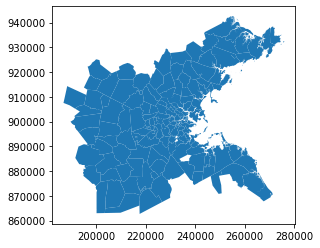

In [22]:
boston_zips.plot()

In [23]:
#read in the tree canopy raster

with rasterio.open('Data/Tree_canopy/NLCD_2016_Tree_Canopy_Boston.tif') as tree:
    shape_tree = tree.shape
    transform_tree = tree.transform
    res_tree = tree.res
    crs_tree = tree.crs
    nodata_tree = tree.nodata
    bounds_tree = tree.bounds
    tree_canopy = tree.read(1)

In [24]:
#count number of bands

tree.count

1

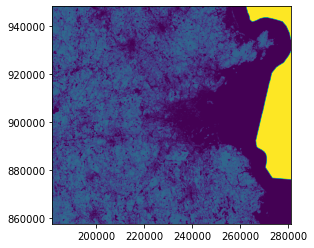

<AxesSubplot:>

In [25]:
#visualize the tree canopy raster


show(tree_canopy, transform=transform_tree)


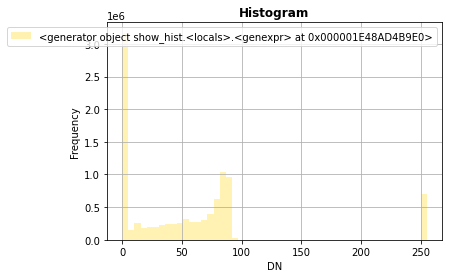

In [26]:
from rasterio.plot import show_hist
show_hist(
tree_canopy, bins=50, lw=0.0, stacked=False, alpha=0.3,
histtype='stepfilled', title="Histogram")

| Min Caonpy Cover         | Max Caonpy Cover         |   Ranking    |
| :----------------------: | :----------------------: | :----------: |
|         ...              |       10%                |        1     |
|     10%                  |       20%                |        2     |
|     20%                  |             30%          |        3     |
|    30%                   |            50%           |        4     |
|    50%                   |            ...           |        5     |


In [27]:
#reclassify tree canopy raster

reclass_tree = np.empty(shape_tree)
reclass_tree[tree_canopy < 10] = 1
reclass_tree[(tree_canopy >= 10) & (tree_canopy < 20)] = 2
reclass_tree[(tree_canopy >= 20) & (tree_canopy < 30)] = 3
reclass_tree[(tree_canopy >= 30) & (tree_canopy < 50)] = 4
reclass_tree[tree_canopy > 50] = 5


In [28]:
reclass_tree

array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 1., 1., 1.],
       [5., 5., 5., ..., 1., 1., 1.],
       [5., 5., 5., ..., 1., 1., 1.]])

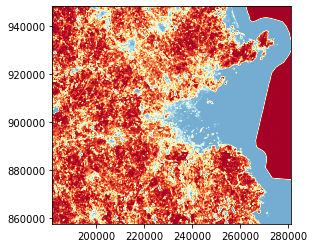

<AxesSubplot:>

In [29]:
show(reclass_tree, transform=transform_tree, cmap='RdYlBu_r')


In [30]:
#read in farmers markets points

markets = gpd.read_file('Data/Farmers_Markets/FARMERSMARKETS_PT/FARMERSMARKETS_PT.shp')

In [31]:
markets.head()

,MARKET_ID,NAME,TYPE,ADDR_1,ADDR_2,TOWN,ZIP_CODE,DAY_TIME,DATES,UPDATE_DAT,YEAR_START,WEBSITE,EBT,WIC_CVV,COUPONS,LONGITUDE,LATITUDE,geometry
0,606.0,Sustainable Nantucket/Wednesday,Farmers Markets,113 Pleasant St.,Next to Glidden's Seafood,Nantucket,02554,"Wednesday, 3:30 pm - 6:30 pm",July 6 to September 14,2016,2016,http://www.sustainablenantucket.org,EBT-SNAP Accepted,None,WIC & Senior Coupons Accepted,-70.09361,41.27301,POINT (317843.084 781295.223)
1,607.0,Holden/Market on Main at Jed's,Farmers Markets,450 Main St.,Jed's Hardware and Garden,Holden,01520,"Friday, 3:30 pm - 7:00 pm",May 20 to October 28,2016,2016,None,None,None,None,-71.83454,42.33213,POINT (172428.679 898013.943)
2,535.0,West Newton,Farmers Markets,Elm Street,off Washington Street,West Newton,02465,"Saturday, 10:00 am - 2:00 pm",June 18 to October 8,2016,2014,http://www.newtonma.gov/gov/parks,EBT-SNAP Accepted,None,WIC & Senior Coupons Accepted,-71.22932,42.34906,POINT (222302.311 899875.783)
3,538.0,Plainville,Farmers Markets,200 South Street,Old Wood School,Plainville,02762,"Sunday, 10:00 am - 2:00 pm",May 25 to November 2,2015,2014,http://www.plainvillefarmersmarket.com/,EBT-SNAP Accepted,None,WIC & Senior Coupons Accepted,-71.33843,42.00941,POINT (213383.817 862127.128)
4,539.0,Worcester Art Museum,Farmers Markets,Lancaster St.,Worcester Art Museum,Worcester,01609,"Saturdays, 10:00 am - 1:00 pm",July 11 to August 29,2015,2014,None,None,None,WIC & Senior Coupons Accepted,-71.80202,42.27328,POINT (175085.678 891467.195)


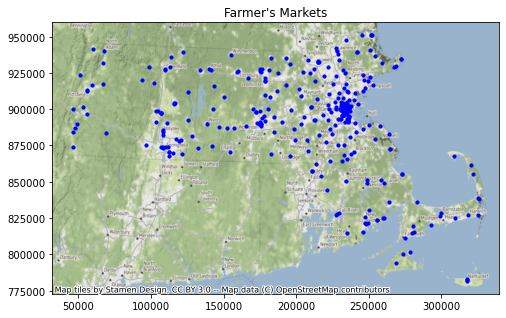

In [32]:
fig, ax = plt.subplots(figsize=(8,5))
markets.plot(ax=ax, color="blue", markersize=10)

plt.title("Farmer's Markets")

cx.add_basemap(ax, crs=markets.crs.to_string())

In [33]:
markets.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [34]:
markets.to_crs('epsg:6491', inplace=True)

In [35]:
markets.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [36]:
#create binary raster

market_raster = features.rasterize(markets['geometry'], out_shape=shape_tree, fill=1, transform=transform_tree, default_value=0)

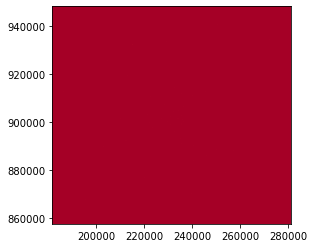

<AxesSubplot:>

In [37]:
show(market_raster, transform=transform_tree, cmap='RdYlBu_r')

In [38]:
#calculate euclidean distance

market_distance = ndimage.distance_transform_edt(market_raster)

In [39]:
market_distance

array([[445.53899942, 445.45706864, 445.37736808, ..., 547.84760655,
        548.38854839, 548.93077888],
       [444.54246141, 444.46034694, 444.38046762, ..., 547.0063985 ,
        547.5481714 , 548.09123328],
       [443.545939  , 443.46364   , 443.38358111, ..., 546.16572576,
        546.70833175, 547.25222704],
       ...,
       [379.42719987, 379.38107491, 379.33758053, ..., 738.46597755,
        739.21918265, 739.97297248],
       [380.42607692, 380.38007308, 380.33669294, ..., 739.12448207,
        739.87701681, 740.63013711],
       [381.42495985, 381.37907651, 381.33581002, ..., 739.78375219,
        740.53561697, 741.28806816]])

In [40]:
res_tree[0]

30.0

In [41]:
#multiply by cell size using the res attribute

market_distance = ndimage.distance_transform_edt(market_raster) * res_tree[0]

In [42]:
market_distance

array([[13366.16998246, 13363.71205915, 13361.32104247, ...,
        16435.42819643, 16451.65645156, 16467.92336635],
       [13336.27384242, 13333.81040813, 13331.41402853, ...,
        16410.191955  , 16426.4451419 , 16442.73699844],
       [13306.37816989, 13303.90919993, 13301.50743337, ...,
        16384.97177294, 16401.24995237, 16417.56681119],
       ...,
       [11382.81599605, 11381.43224731, 11380.12741581, ...,
        22153.97932652, 22176.57547955, 22199.18917438],
       [11412.78230757, 11411.40219254, 11410.10078834, ...,
        22173.7344622 , 22196.31050423, 22218.90411339],
       [11442.74879563, 11441.37229531, 11440.07430046, ...,
        22193.51256561, 22216.06850908, 22238.64204487]])

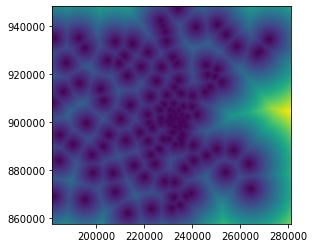

<AxesSubplot:>

In [43]:
#visualized euclidean distance

show(market_distance, transform=transform_tree)

| Min Distance (Inclusive) | Max Distance (Exclusive) |   Ranking    |
| :----------------------: | :----------------------: | :----------: |
|            ...           |     0.5 mile (804.67 m)  |        5     |
|     0.5 mile (804.67 m)  |     1 miles (1609.34 m)  |        4     |
|     1 miles (1609.34 m)  |    2.5 miles (4023.36 m) |        3     |
|    2.5 miles (4023.36 m) |    5 miles (8046.72 m)   |        2     |
|    5 miles (8046.72 m)   |            ...           |        1     |


In [44]:
#reclassify farmers market raster

reclass_market = np.empty(shape_tree)
reclass_market[market_distance < 804.67] = 5
reclass_market[(market_distance >= 804.67) & (market_distance < 1609.34)] = 4
reclass_market[(market_distance >= 1609.34) & (market_distance < 4023.36)] = 3
reclass_market[(market_distance >= 4023.36) & (market_distance < 8046.72)] = 2
reclass_market[market_distance > 8046.72] = 1


In [45]:
reclass_market

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

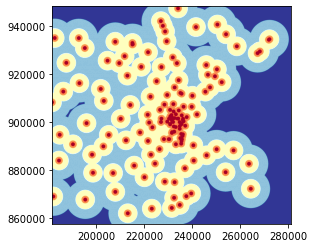

<AxesSubplot:>

In [46]:
show(reclass_market, transform=transform_tree, cmap='RdYlBu_r')


In [47]:
#read in bike trails shapefile

trails = gpd.read_file('Data/biketrails_arc/biketrails_arc.shp')

In [48]:
trails.head()

,TRAIL_STAT,OWNER,PREV_OWNER,MANAGER,STATUS_OWN,STATUS_MAN,TRAILNAME,LINENAME,CONTACT1,CONTACT2,OPENED,COMPLETED,SHAPE_LEN,geometry
0,A,None,None,None,None,None,None,None,None,None,0,0,2682.148826,"LINESTRING (155011.720 938176.872, 154856.140 ..."
1,A,None,None,None,None,None,None,None,None,None,0,0,3185.285762,"LINESTRING (152703.300 940805.062, 152825.270 ..."
2,A,MBTA,B&M,STONEHAM,S,M,None,STONEHAM BRANCH,None,None,0,0,1023.995413,"LINESTRING (236337.770 919351.692, 236358.080 ..."
3,A,EOTC,Penn Central,None,S,None,None,RANDOLPH SECONDARY,None,None,0,0,3539.237640,"LINESTRING (240197.230 881487.872, 240032.340 ..."
4,A,EOTC,Penn Central,None,S,None,None,E BRIDGEWATER SECONDARY,None,None,0,0,3179.001331,"LINESTRING (244758.840 865107.752, 244476.770 ..."


In [49]:
trails.to_crs('epsg:6491', inplace=True)

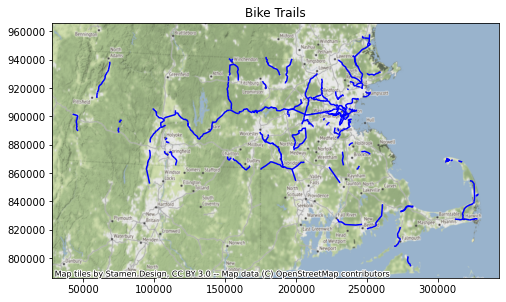

In [50]:


fig, ax = plt.subplots(figsize=(8,5))
trails.plot(ax=ax, color="blue", markersize=10)
plt.title('Bike Trails')

cx.add_basemap(ax, crs=markets.crs.to_string())

In [51]:
trails.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [52]:
#make trails into binary raster

trails_raster = features.rasterize(trails['geometry'], out_shape=shape_tree, fill=1, transform=transform_tree, default_value=0)

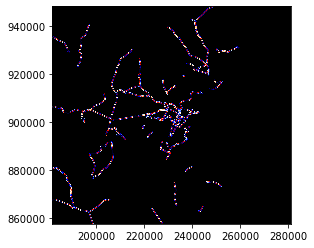

<AxesSubplot:>

In [53]:
show(trails_raster, transform=transform_tree, cmap='flag')

In [54]:
#calculate euclidean distance

trails_distance = ndimage.distance_transform_edt(trails_raster)

In [55]:
trails_distance

array([[ 424.        ,  424.00117924,  424.00471695, ...,  925.17673987,
         925.95950235,  926.74268273],
       [ 423.        ,  423.00118203,  423.00472811, ...,  924.55448731,
         925.33777617,  926.12148231],
       [ 422.        ,  422.00118483,  422.00473931, ...,  923.932898  ,
         924.71671338,  925.50094543],
       ...,
       [ 328.        ,  328.00152439,  328.0060975 , ..., 1093.88527735,
        1094.7666418 , 1095.64820997],
       [ 329.        ,  329.00151975,  329.00607897, ..., 1094.35825944,
        1095.23924327, 1096.12043134],
       [ 330.        ,  330.00151515,  330.00606055, ..., 1094.83195058,
        1095.71255355, 1096.59336128]])

In [56]:
#multiply by cell size using the res attribute

trails_distance = ndimage.distance_transform_edt(trails_raster) * res_tree[0]

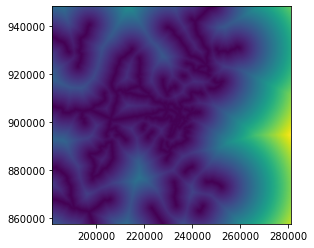

<AxesSubplot:>

In [57]:
#visualized euclidean distance

show(trails_distance, transform=transform_tree)

| Min Distance (Inclusive) | Max Distance (Exclusive) |   Ranking    |
| :----------------------: | :----------------------: | :----------: |
|            ...           |     1 mile (1609.34 m)   |        5     |
|     1 mile (1609.34 m)   |     2 miles (3218.69 m)  |        4     |
|     2 miles (3218.69 m)  |     3 miles (4828.03)    |        3     |
|    3 miles (4828.03)     |    7 miles (11265.4)     |        2     |
|    7 miles (11265.4)     |            ...           |        1     |


In [58]:
#reclassify bike trails raster

reclass_trails = np.empty(shape_tree)
reclass_trails[trails_distance < 1609.34] = 5
reclass_trails[(trails_distance >= 1609.34) & (trails_distance < 3218.69)] = 4
reclass_trails[(trails_distance >= 3218.69) & (trails_distance < 4828.03)] = 3
reclass_trails[(trails_distance >= 4828.03) & (trails_distance < 11265.4)] = 2
reclass_trails[trails_distance > 11265.4] = 1

In [59]:
reclass_trails

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [2., 2., 2., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.]])

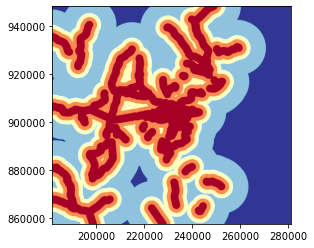

<AxesSubplot:>

In [60]:
show(reclass_trails, transform=transform_tree, cmap='RdYlBu_r')

In [61]:
#read in DCR pools layer

pools = gpd.read_file('Data/Public_Pools/DCRPOOLS_PT.shp')

In [62]:
pools.to_crs('epsg:6491', inplace=True)

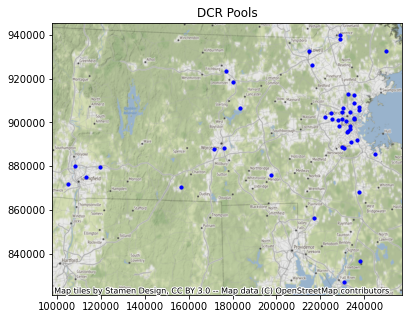

In [63]:


fig, ax = plt.subplots(figsize=(8,5))
pools.plot(ax=ax, color="blue", markersize=10)
plt.title('DCR Pools')

cx.add_basemap(ax, crs=pools.crs.to_string())

In [64]:
pools.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [65]:
pools.head()

,NAME,TYPE,STATUS,LIFEGUARD,ACCESSIBLE,ADDRESS,TOWN,PHONE,REGION,DISTRICT,LABEL,LEGISLATIO,COMMENTS,FOT,POOL_ID,geometry
0,Lieutenant James F. Reilly Memorial Recreation...,Swimming Pool,Open,Yes,No,355 Chestnut Hill Avenue,Boston,617-277-7822,Boston,Neponset Stony Brook,Reilly Pool,"Acts 1961, Chapter 446",None,Stony Brook,121,POINT (228695.209 898490.128)
1,Francis J. McCrehan Swimming Pool,Swimming and Wading Pool,Open,Yes,No,359 Rindge Avenue,Cambridge,617-661-0670,Boston,Rivers,McCrehan Pool,"Acts 1960, Chapter 564",None,Mystic River,122,POINT (229869.767 904985.642)
2,Everett Allied War Veterans' Memorial Recreati...,Swimming and Wading Pool,Open,Yes,Yes,65 Elm Street,Everett,617-727-1828,North,Coastal,Allied Veterans Pool,"Acts 1961, Chapter 461",None,Revere Beach,123,POINT (237585.286 907032.062)
3,Vietnam Veterans Memorial Pool,Swimming and Wading Pool,Open,Yes,Yes,184 Carter Street,Chelsea,617-884-3899,North,Coastal,Vietnam Veterans Pool,"Acts 1968, Chapter 527",None,Revere Beach,124,POINT (237942.605 905699.988)
4,Veterans Memorial Pool,Swimming and Wading Pool,Open,Yes,No,719 Memorial Drive,Cambridge,617-661-0564,Boston,Rivers,Veterans Pool,None,None,Charles,125,POINT (231675.077 900783.912)


In [66]:
#make pools into binary raster

pools_raster = features.rasterize(pools['geometry'], out_shape=shape_tree, fill=1, transform=transform_tree, default_value=0)

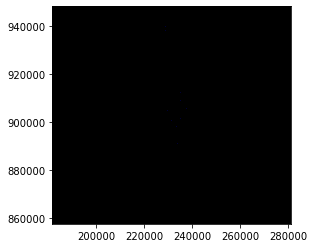

<AxesSubplot:>

In [67]:
show(pools_raster, transform=transform_tree, cmap='flag')

In [68]:
#calculate euclidean distance

pools_distance = ndimage.distance_transform_edt(pools_raster)

In [69]:
pools_distance

array([[1215.76642494, 1214.8633668 , 1213.96046064, ..., 1164.09707499,
        1164.99141628, 1165.88592924],
       [1215.33740171, 1214.43402456, 1213.53079895, ..., 1163.64986143,
        1164.54454616, 1165.43940211],
       [1214.90905009, 1214.00535419, 1213.10180941, ..., 1163.20333562,
        1164.09836354, 1164.99356221],
       ...,
       [ 804.92049297,  804.26985521,  803.61993504, ..., 1498.18056322,
        1499.15242721, 1500.12432818],
       [ 805.67983716,  805.02981311,  804.38050697, ..., 1498.41649751,
        1499.38820857, 1500.35995681],
       [ 806.43970636,  805.7902953 ,  805.14160245, ..., 1498.65306192,
        1499.6246197 , 1500.59621484]])

In [70]:
#multiply by cell size using the res attribute

pools_distance = ndimage.distance_transform_edt(pools_raster) * res_tree[0]

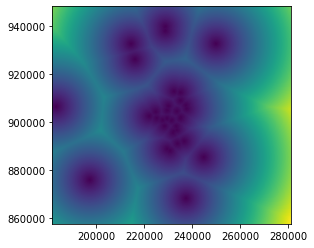

<AxesSubplot:>

In [71]:
show(pools_distance, transform=transform_tree)

| Min Distance (Inclusive) | Max Distance (Exclusive) |   Ranking    |
| :----------------------: | :----------------------: | :----------: |
|            ...           |     0.5 mile (804.67 m)  |        5     |
|     0.5 mile (804.67 m)  |     1 miles (1609.34 m)  |        4     |
|     1 miles (1609.34 m)  |    2.5 miles (4023.36 m) |        3     |
|    2.5 miles (4023.36 m) |    5 miles (8046.72 m)   |        2     |
|    5 miles (8046.72 m)   |            ...           |        1     |


In [72]:
#reclassify pools

reclass_pools = np.empty(shape_tree)
reclass_pools[pools_distance < 804.67] = 5
reclass_pools[(pools_distance >= 804.67) & (pools_distance < 1609.34)] = 4
reclass_pools[(pools_distance >= 1609.34) & (pools_distance < 4023.36)] = 3
reclass_pools[(pools_distance >= 4023.36) & (pools_distance < 8046.72)] = 2
reclass_pools[pools_distance > 8046.72] = 1


In [73]:
reclass_pools

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

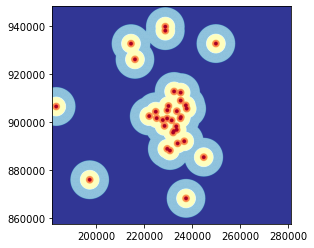

<AxesSubplot:>

In [74]:
show(reclass_pools, transform=transform_tree, cmap='RdYlBu_r')


In [75]:
#read in blue bikes csv

blue_bikes = pd.read_csv('Data/Blue_Bikes/current_bluebikes_stations.csv')

In [76]:
blue_bikes.head()

,Number,Name,Latitude,Longitude,District,Public,Total docks
0,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11
1,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18
2,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19
3,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17
4,S32023,30 Dane St,42.381001,-71.104025,Somerville,Yes,15


In [77]:
#make into a geodataframe

bb_stations = gpd.GeoDataFrame(blue_bikes, geometry=gpd.points_from_xy(blue_bikes.Longitude, blue_bikes.Latitude))

In [78]:
bb_stations.crs

In [79]:
#set crs for bb_stations

bb_stations.set_crs('epsg:4326', inplace=True)

,Number,Name,Latitude,Longitude,District,Public,Total docks,geometry
0,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,POINT (-71.17569 42.36466)
1,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18,POINT (-71.12916 42.36380)
2,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,POINT (-71.10879 42.38032)
3,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,POINT (-71.09500 42.28887)
4,S32023,30 Dane St,42.381001,-71.104025,Somerville,Yes,15,POINT (-71.10403 42.38100)
...,...,...,...,...,...,...,...,...
367,N32006,West Newton Armory,42.349472,-71.220007,Newton,Yes,11,POINT (-71.22001 42.34947)
368,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,19,POINT (-71.14393 42.36179)
369,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,POINT (-71.09219 42.33286)
370,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,19,POINT (-71.10767 42.30654)


In [80]:
bb_stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [81]:
bb_stations.to_crs('epsg:6491', inplace=True)

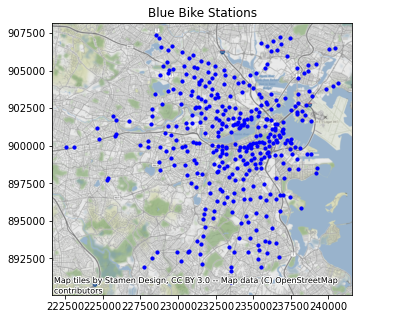

In [82]:

fig, ax = plt.subplots(figsize=(8,5))
bb_stations.plot(ax=ax, color="blue", markersize=10)
plt.title('Blue Bike Stations')

cx.add_basemap(ax, crs=markets.crs.to_string())

In [83]:
bb_stations.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [84]:
bb_stations.head()

,Number,Name,Latitude,Longitude,District,Public,Total docks,geometry
0,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,POINT (226714.154 901624.425)
1,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18,POINT (230547.368 901543.626)
2,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,POINT (232217.550 903386.915)
3,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,POINT (233400.854 893234.040)
4,S32023,30 Dane St,42.381001,-71.104025,Somerville,Yes,15,POINT (232609.271 903464.043)


In [85]:
#make bluebikes stations into binary raster

bb_raster = features.rasterize(bb_stations['geometry'], out_shape=shape_tree, fill=1, transform=transform_tree, default_value=0)

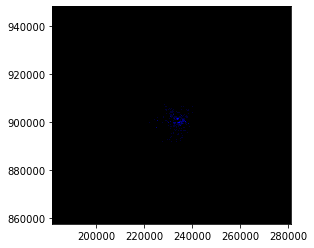

<AxesSubplot:>

In [86]:
show(bb_raster, transform=transform_tree, cmap='flag')

In [87]:
#calculate euclidean distance

bb_distance = ndimage.distance_transform_edt(bb_raster)

In [88]:
bb_distance

array([[2074.10342076, 2073.35187559, 2072.60054038, ..., 1951.03075322,
        1951.73000182, 1952.42951217],
       [2073.4439949 , 2072.69221063, 2071.94063622, ..., 1950.31587185,
        1951.01537667, 1951.71514315],
       [2072.7848417 , 2072.03281827, 2071.2810046 , ..., 1949.60124128,
        1950.30100241, 1951.00102512],
       ...,
       [1910.4159233 , 1909.61357348, 1908.81141028, ..., 1887.17063351,
        1887.95868599, 1888.74693911],
       [1911.01282047, 1910.21072136, 1909.40880903, ..., 1887.78653454,
        1888.57433002, 1889.36232629],
       [1911.61005438, 1910.80820597, 1910.00654449, ..., 1888.40276424,
        1889.19030275, 1889.9780422 ]])

In [89]:
#multiply by cell size using the res attribute

bb_distance = ndimage.distance_transform_edt(bb_raster) * res_tree[0]

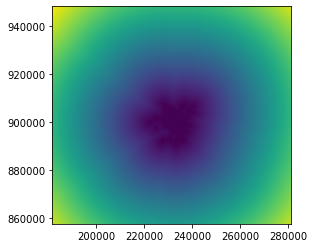

<AxesSubplot:>

In [90]:
show(bb_distance, transform=transform_tree)

| Min Distance (Inclusive) | Max Distance (Exclusive) |   Ranking    |
| :----------------------: | :----------------------: | :----------: |
|            ...           |   0.25 miles (402.336 m) |        5     |
|   0.25 mile (402.336 m)  |    .5 miles (804.672 m)  |        4     |
|    .5 miles (804.672 m)  |    2 miles (3218.69 m)   |        3     |
|    2 miles (3218.69 m)   |    5 miles (8046.72 m)   |        2     |
|    5 miles (8046.72 m)   |            ...           |        1     |


In [91]:
#reclassify bb

reclass_bb = np.empty(shape_tree)
reclass_bb[bb_distance < 402.336] = 5
reclass_bb[(bb_distance >= 402.336) & (bb_distance < 804.672)] = 4
reclass_bb[(bb_distance >= 804.672) & (bb_distance < 3218.69)] = 3
reclass_bb[(bb_distance >= 3218.69) & (bb_distance < 8046.72)] = 2
reclass_bb[bb_distance > 8046.72] = 1


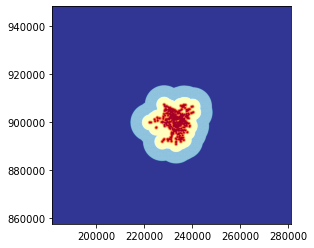

<AxesSubplot:>

In [92]:
show(reclass_bb, transform=transform_tree, cmap='RdYlBu_r')

| Component                |        Weight            |   
| :----------------------: | :----------------------: | 
|    Distance to trails    |             30%          |      
|    Distance to bluebikes |            30%           |       
|       Tree canopy        |           18%            |      
| Distance to Public Pools |            12%           |      
|Distance to Farm. Markets |            10%           |       


In [93]:
#add up all reclassified rasters

raster_sum = reclass_trails + reclass_bb + reclass_tree + reclass_pools + reclass_market

In [94]:
raster_sum

array([[ 9.,  9.,  9., ...,  9.,  9.,  9.],
       [ 9.,  9.,  9., ...,  9.,  9.,  9.],
       [ 9.,  9.,  9., ...,  9.,  9.,  9.],
       ...,
       [10., 10., 10., ...,  5.,  5.,  5.],
       [10., 10., 10., ...,  5.,  5.,  5.],
       [10., 10., 10., ...,  5.,  5.,  5.]])

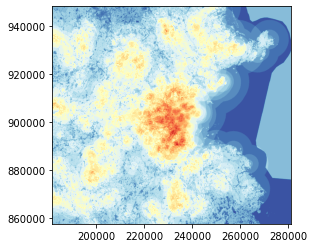

<AxesSubplot:>

In [95]:
show(raster_sum, transform=transform_tree, cmap='RdYlBu_r')

In [96]:
#create a weighted suitability

weighted_or = reclass_trails * .3 + reclass_bb * .3 + reclass_tree * .18 + reclass_pools * .12 + reclass_market * .1

In [97]:
weighted_or

array([[1.72, 1.72, 1.72, ..., 1.72, 1.72, 1.72],
       [1.72, 1.72, 1.72, ..., 1.72, 1.72, 1.72],
       [1.72, 1.72, 1.72, ..., 1.72, 1.72, 1.72],
       ...,
       [2.02, 2.02, 2.02, ..., 1.  , 1.  , 1.  ],
       [2.02, 2.02, 2.02, ..., 1.  , 1.  , 1.  ],
       [2.02, 2.02, 2.02, ..., 1.  , 1.  , 1.  ]])

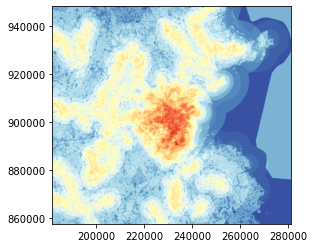

<AxesSubplot:>

In [98]:
show(weighted_or, transform=transform_tree, cmap='RdYlBu_r')

In [99]:
boston_zips.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
17,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"MULTIPOLYGON (((243877.753 913824.638, 243872...."
18,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245700.484 914778.700, 245667.412 91..."
20,25,01930,2501930,B5,G6350,S,67847425,13972397,+42.6199100,-070.6818235,N,"MULTIPOLYGON (((261745.067 931625.267, 261822...."
21,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"MULTIPOLYGON (((250787.714 926889.372, 251155...."
22,25,01921,2501921,B5,G6350,S,61010486,2188501,+42.6831083,-071.0183302,N,"MULTIPOLYGON (((245193.985 936821.773, 244097...."


In [100]:

#create a binary raster using rasterio rasterize function

bosmpo_raster = features.rasterize(boston_zips['geometry'], out_shape=shape_tree, fill=1, transform=transform_tree, default_value=0)


In [101]:
#use boolean indexing to assign np.NaN to all the cells not in Boston MPO

weighted_or[bosmpo_raster == 1] = np.NaN

In [102]:
weighted_or

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

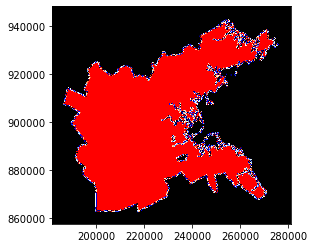

In [103]:
show(bosmpo_raster, transform=transform_tree, cmap='flag')
plt.show()

In [104]:
#define a function to get coordinates of raster

def get_extent(array, transform):
    """
    Outputs the spatial extent of a raster based on the
    shape of the array and its' transform
    """
    left, top = transform * (0, 0)
    right, bottom = transform * array.shape
    extent = (left, right, bottom, top)
    return extent




In [105]:
get_extent(weighted_or, transform_tree)

(181770.0, 272490.0, 848730.0, 948390.0)

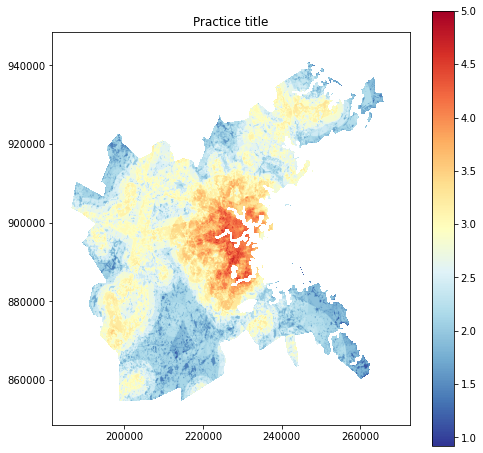

In [106]:
#visualize raster nicely 



fig, ax = plt.subplots(figsize=(8,8))
image = ax.imshow(weighted_or, cmap="RdYlBu_r", 
                  extent = get_extent(weighted_or, transform_tree))
fig.colorbar(image)
plt.title("Practice title")
plt.show()

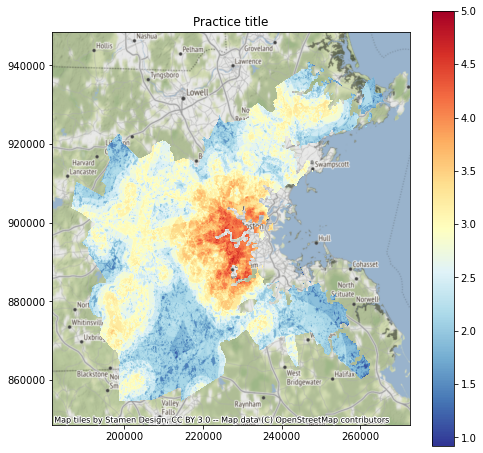

In [107]:
#visualize raster nicely with basemap- attempt

fig, ax = plt.subplots(figsize=(8,8))
ax.axis(get_extent(weighted_or, transform_tree))
cx.add_basemap(ax, crs='EPSG:6491')
image = ax.imshow(weighted_or, cmap="RdYlBu_r",
                  extent = get_extent(weighted_or, transform_tree))
fig.colorbar(image)
plt.title("Practice title")

plt.show()

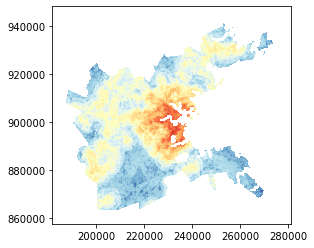

<AxesSubplot:>

In [108]:
#show weighted suitability just in Boston

show(weighted_or, transform=transform_tree, cmap='RdYlBu_r')


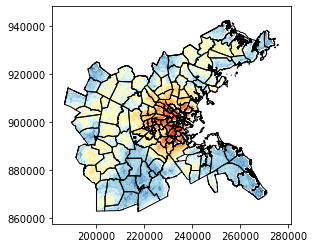

In [109]:
#overlay zip code boundaries

ax= boston_zips.plot(facecolor='None', edgecolor='black')
show(weighted_or, cmap='RdYlBu_r', ax=ax, transform=transform_tree)
plt.show()

In [110]:
#find zonal statistics

stats = pd.DataFrame(zonal_stats(boston_zips, weighted_or, affine=transform_tree, stats=['mean'], nodata=np.NaN))

In [111]:
stats.head()

,mean
0,2.877546
1,2.344685
2,2.064128
3,2.298088
4,2.797419


In [112]:
#reset index 

index_reset_zips = boston_zips.reset_index()

In [113]:
#join stats to boston zip code polygons

zips_stats = index_reset_zips.join(stats)

In [114]:
zips_stats.head()

,index,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,mean
0,17,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"MULTIPOLYGON (((243877.753 913824.638, 243872....",2.877546
1,18,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245700.484 914778.700, 245667.412 91...",2.344685
2,20,25,01930,2501930,B5,G6350,S,67847425,13972397,+42.6199100,-070.6818235,N,"MULTIPOLYGON (((261745.067 931625.267, 261822....",2.064128
3,21,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"MULTIPOLYGON (((250787.714 926889.372, 251155....",2.298088
4,22,25,01921,2501921,B5,G6350,S,61010486,2188501,+42.6831083,-071.0183302,N,"MULTIPOLYGON (((245193.985 936821.773, 244097....",2.797419


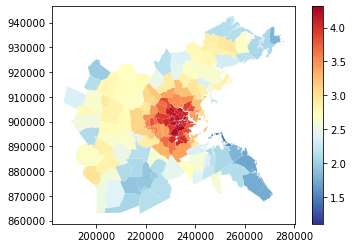

In [115]:
zips_stats.plot(column='mean', cmap='RdYlBu_r', legend=True)
plt.show()

In [116]:
zips_stats.head()

,index,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,mean
0,17,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"MULTIPOLYGON (((243877.753 913824.638, 243872....",2.877546
1,18,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245700.484 914778.700, 245667.412 91...",2.344685
2,20,25,01930,2501930,B5,G6350,S,67847425,13972397,+42.6199100,-070.6818235,N,"MULTIPOLYGON (((261745.067 931625.267, 261822....",2.064128
3,21,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"MULTIPOLYGON (((250787.714 926889.372, 251155....",2.298088
4,22,25,01921,2501921,B5,G6350,S,61010486,2188501,+42.6831083,-071.0183302,N,"MULTIPOLYGON (((245193.985 936821.773, 244097....",2.797419


In [118]:
best_zips = zips_stats.sort_values(by='mean', ascending=False).head()
best_zips.ZCTA5CE10

68     02163
173    02120
66     02119
113    02114
49     02140
Name: ZCTA5CE10, dtype: object

In [119]:
worst_zips = zips_stats.sort_values(by='mean', ascending=True).head()
worst_zips.ZCTA5CE10

88     02047
15     02359
145    02045
57     02762
14     02066
Name: ZCTA5CE10, dtype: object

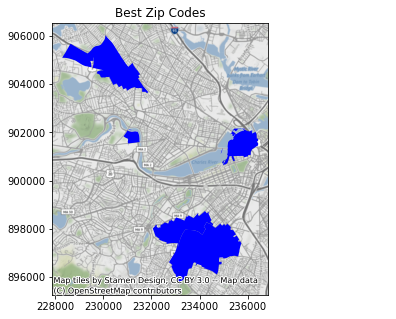

In [121]:
fig, ax = plt.subplots(figsize=(8,5))
best_zips.plot(ax=ax, color="blue", markersize=10)
plt.title('Best Zip Codes')

cx.add_basemap(ax, crs=markets.crs.to_string())

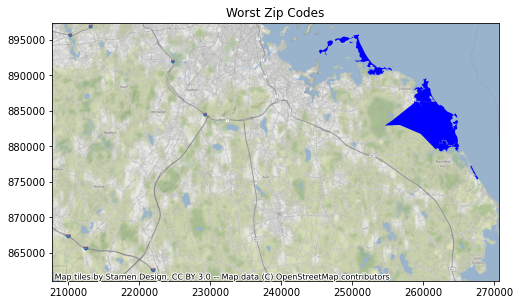

In [122]:
fig, ax = plt.subplots(figsize=(8,5))
worst_zips.plot(ax=ax, color="blue", markersize=10)
plt.title('Worst Zip Codes')

cx.add_basemap(ax, crs=markets.crs.to_string())

In [127]:
int_map = folium.Map(location=[42.3601, -71.0589], 
                         default_zoom_start=15)
int_map

In [128]:
folium.GeoJson(data=best_zips["geometry"]).add_to(int_map)

int_map